<a href="https://colab.research.google.com/github/sahilfaizal01/100-Days-Of-ML-Code/blob/master/Another_copy_of_ML_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Basics of numpy, CV, NLP


In [ ]:
import numpy as np
# convolution, not optimized, might need to write a version for causal and dilated conv
N = 20
kernel_size = 3
img = np.ones((N,N))
kernel = np.arange(1,kernel_size*kernel_size + 1).reshape((kernel_size,-1))
output = np.zeros((N-2,N-2))
for i in range(1, N-1):
    for j in range(1,N-1):
        # pivot point is i,j
        local = img [i-1:i+2, j-1:j+2]
        conv = np.sum(local * kernel)
        output[i-1, j-1] = conv
print(output.shape)

(18, 18)


## Torch Operations

In [ ]:
import torch
import numpy as np
# normally we have two ways of representing a sequence of items
# say the values are represented by a matrix of (bz, seq_len)
bz, seq_len = 3, 3
values = torch.arange(bz * seq_len).view(bz,seq_len)
# common operations are
########## 1. mask operation ##############
# a mask of shape (bz, seq_len) is also given
mask= torch.ones((bz, seq_len), device=values.device).long()
mask[1, 1:] = 0 # make a pseudo mask matrix that mask out part of second sample
mask = mask.bool()
# now we directly use the boolean mask to update the position
values[~mask] = -1
print(values)

# it is also easy to obtain the sequence length of each sample by sum
token_length = mask.sum(dim=-1)
# and we can inverse the operation by torch arange with max seq_len
max_token_len = token_length.max().item()

# use arange to create indice matrix and expand it to batch size
new_mask = torch.arange(max_token_len).unsqueeze(0).expand(bz, -1)
# then check the length to convert it to original mask
new_mask = new_mask < token_length.unsqueeze(0).view(bz, -1)
assert torch.equal(new_mask, mask)

tensor([[ 0,  1,  2],
        [ 3, -1, -1],
        [ 6,  7,  8]])


In [ ]:
######## 2. Scores Distribution Selection #################
# suppose we have a score distribution (could be prob distribution or categorical values)
bz, seq_len = 3, 5
scores = torch.tensor([1.0,3,5,7,2]).unsqueeze(0).expand(3, -1).clone()
# create a pseudo mask
mask = torch.ones((bz, seq_len), device=scores.device).long()
mask[1, 3:] = 0
mask[2, 2:] = 0
mask = mask.bool()
scores[~mask] = -1
print(scores)
n_tok = mask.sum(-1)
n_tok_exp = (n_tok -1).unsqueeze(1) # (bz,1)
print(n_tok_exp)
"""
now we can use scatter to write the values of scores along dimension 1
scatter_(dim, index, src, reduce=None) means:
    self[index[i][j][k]][j][k] = src[i][j][k]  # if dim == 0
    self[i][index[i][j][k]][k] = src[i][j][k]  # if dim == 1
    self[i][j][index[i][j][k]] = src[i][j][k]  # if dim == 2
    note than index and src does not broadcast
    see https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_.html#torch.Tensor.scatter_
    for more examples
    >>> src = torch.arange(1, 11).reshape((2, 5))
    tensor([[ 1,  2,  3,  4,  5],
            [ 6,  7,  8,  9, 10]])
    >>> index = torch.tensor([[0, 1, 2, 0]])
    >>> torch.zeros(3, 5, dtype=src.dtype).scatter_(0, index, src)
    tensor([[1, 0, 0, 4, 0],
            [0, 2, 0, 0, 0],
            [0, 0, 3, 0, 0]])

    zeros[[index[i][j]][j]] = src[i][j]
    when i=j=0, zeros[0,0] = src[0,0] = 1
    when i=0, j=1, zeros[1,1] = src[0,1] =2
    when i=0, j=2, zeros[2, 2] = src[0,2] = 3
    when i=0, j=3, zeros[0, 3] = src[0,3] = 4
    This is very powerful, as we basically can scatter the values from src
    into self with a customized function over certain dimension

    some useful settings:
    a = # shape [B, N, k], where B is batch size, N is number of points, k is the index number within [0,V] to select feature.
    b = # shape [B, N, k], where B is batch size, N is number of points, k stores here the weights for selected feature.
    then we can do weights.scatter_(dim=2, index=a, src=b) which corresponds to
    weight[i, j, a[i,j] ] = b[i, j, k] which uses index matrix a to put values from b into the out (weights) matrix

"""


"""
    so for our example below, it writes
    scores[i][index[i][j]] = src[i][j] = max_value[i][j] = float('inf')
    which makes each last position to be maximum values
"""
scores = scores.scatter(
    1, n_tok_exp,
    scores.new_full(n_tok_exp.shape, fill_value=torch.finfo(scores.dtype).max)
)

print(scores)

tensor([[ 1.,  3.,  5.,  7.,  2.],
        [ 1.,  3.,  5., -1., -1.],
        [ 1.,  3., -1., -1., -1.]])
tensor([5, 3, 2])
tensor([[4],
        [2],
        [1]])
tensor([[ 1.0000e+00,  3.0000e+00,  5.0000e+00,  7.0000e+00,  3.4028e+38],
        [ 1.0000e+00,  3.0000e+00,  3.4028e+38, -1.0000e+00, -1.0000e+00],
        [ 1.0000e+00,  3.4028e+38, -1.0000e+00, -1.0000e+00, -1.0000e+00]])


In [ ]:
# Torch Index Put
"""
Similar to scatter, another commonly used operation is torch.index_put_
torch.index_put_(indices, values) is in-place operation that put values
into self along the indices
"""

# reuse previous code for init
bz, seq_len = 3, 5
scores = torch.tensor([1.0,3,5,7,2]).unsqueeze(0).expand(3, -1).clone()
# create a pseudo mask
mask = torch.ones((bz, seq_len), device=scores.device).long()
mask[1, 3:] = 0
mask[2, 2:] = 0
mask = mask.bool()
scores[~mask] = -1
print(scores)

# normally we make a out matric with +1 column for pad
out = torch.zeros((bz, 10))
# now suppose each of the sample in the batch correspond to a different ranges
# in the out matrix, we need index put to customize the indices
# here -1 correspond to pad/mask
indices = torch.tensor(
    [
        [2,3,4,5,6],
        [3,4,5,-1,-1],
        [0,1,-1,-1,-1]
    ])
print(indices)

# the indice here is a tuple of size dim (in this example we have dim=2)
out.index_put_(
    (
        torch.arange(bz).view(-1, 1),
        indices
    ),
    scores
)

print(out)


out = torch.zeros((bz, 10))
# the function above can be achieved through scatter_ as well
# we only need to specify the index conversion along second dimension
# not that scatter does not work with -1 index, so we need to use max_len
# to replace the padded position
max_len=9
indices = torch.tensor(
    [
        [2,3,4,5,6],
        [3,4,5,max_len,max_len],
        [0,1,max_len,max_len,max_len]
    ])
out = out.scatter(
    dim=1,
    index=indices,
    src=scores
)
print(out)

# lastly, index put can also be easily write in advanced indexing format
out = torch.zeros((bz, 10))
out[torch.arange(bz).view(-1, 1), indices] = scores
print(out)

tensor([[ 1.,  3.,  5.,  7.,  2.],
        [ 1.,  3.,  5., -1., -1.],
        [ 1.,  3., -1., -1., -1.]])
tensor([[ 2,  3,  4,  5,  6],
        [ 3,  4,  5, -1, -1],
        [ 0,  1, -1, -1, -1]])
tensor([[ 0.,  0.,  1.,  3.,  5.,  7.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  3.,  5.,  0.,  0.,  0., -1.],
        [ 1.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])
tensor([[ 0.,  0.,  1.,  3.,  5.,  7.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  3.,  5.,  0.,  0.,  0., -1.],
        [ 1.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])
tensor([[ 0.,  0.,  1.,  3.,  5.,  7.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  3.,  5.,  0.,  0.,  0., -1.],
        [ 1.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])


In [ ]:
# Torch Gather
"""
The previous methods like advance indexing, scatter or indedx_put are all
equivalent ways of putting items from certain src matrix to a target output matrix
along customized indice matrix. While scatter is the most general form, index put
and adavnce indexing are enough for most tasks.


Now we look at the inverse operation of scatter -- torch.gather, which is used
to retrieve information rather than putting information along some indices and dimension

Since we already understand scatter, gather is supper easy. It is simply selecting
item based on index matrix along some dimension
torch.gather(input, dim, index, *, sparse_grad=False, out=None)
out[i][j][k] = input[index[i][j][k]][j][k]  # if dim == 0
out[i][j][k] = input[i][index[i][j][k]][k]  # if dim == 1
out[i][j][k] = input[i][j][index[i][j][k]]  # if dim == 2
"""
t = torch.tensor([[1, 2], [3, 4]])
indices = torch.tensor([[0, 0], [1, 0]])
out = torch.gather(t, 1, indices)
print(t)
print(out)

"""
more general setting, we have indices that choose the selected representation of
each sample, it has shape (B, h). And our input x is all representation of shape
(B, N, H). then gather along dim=1 would select out our wanted representation
"""
x = torch.arange(3 * 4 * 10).view(3, 4, 10)
# print(x)
max_len=3 # like scatter, it also does not work with -1 for padding
index = torch.tensor([
    [0, 1, 2],
    [1,2, max_len],
    [0,max_len, max_len]
])
# B, h, H
out = torch.gather(x, 1, index.unsqueeze(2).expand(-1,-1,10))
print(out)

# again, we can do this with advance indexing directly
tmp = x[torch.arange(bz).unsqueeze(1), index]
tmp.shape

tensor([[1, 2],
        [3, 4]])
tensor([[1, 1],
        [4, 3]])
tensor([[[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
         [ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19],
         [ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29]],

        [[ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59],
         [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69],
         [ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79]],

        [[ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89],
         [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
         [110, 111, 112, 113, 114, 115, 116, 117, 118, 119]]])


torch.Size([3, 3, 10])

In [ ]:
def get_valid_mask_indices(mask: torch.Tensor, padding_value: int = -1) -> torch.Tensor:
    """ helper function for ctc indice selection """
    assert (
            len(mask.shape) <= 2
    ), f"Only supports 1D or 2D tensors - got {len(mask.shape)}."
    max_valid = mask.sum(dim=-1).max().item()
    n_nugget = mask.sum(dim=-1)
    # Uses the stable flag to ensure their original order is preserved
    sorted_mask, sorted_indices = torch.sort(
        mask.float(), dim=-1, descending=True, stable=True
    )
    valid_indices = (
        sorted_indices[:, :max_valid]
        if len(mask.shape) == 2
        else sorted_indices[:max_valid]
    )
    valid_indices[
        ~(
            sorted_mask.bool()[:, :max_valid]
            if len(mask.shape) == 2
            else sorted_mask.bool()[:max_valid]
        )
    ] = padding_value
    return valid_indices, max_valid, n_nugget

mask = torch.tensor([
    [1,0,0,1,1],
    [1,1,0,0,0],
    [0,1,0,1,0]
])
"""
this function returns the index of non-zeero position of our mask
this is useful when mask is no longer continous as in our previous example,
so arange with comparison won't work anymore and sorting is required
"""
valid_indices, max_valid, n_tok = get_valid_mask_indices(mask)
print(valid_indices)
print(max_valid, n_tok)

tensor([[ 0,  3,  4],
        [ 0,  1, -1],
        [ 1,  3, -1]])
3 tensor([3, 2, 2])


# Linear Regression

### Linear Regression Basics
- A linear combination of known $\phi_k(\cdot)$ functions (basis functions)

>$\displaystyle f(x;\boldsymbol{\beta}) = \sum_{k=1}^K \beta_k\, \phi_k(x) $
> <br/><br/>
> It's a dot product
> <br/><br/>
>$\displaystyle f(x;\boldsymbol{\beta}) = \boldsymbol\beta^T \boldsymbol\phi(x)$
> <br/><br/>
>with $\boldsymbol{\beta}=(\beta_1,\dots,\beta_K)^T$


- Linear in $\boldsymbol{\beta}$, cost function is quadratic

>$\displaystyle C = \sum_{i=1}^N \left\{ y_i - \sum_{k=1}^K \beta_k\, \phi_k(x_i) \right\}^2$

- Solution:

>$\displaystyle X^T y = X^T X \hat{\beta} $
> <br/><br/>
>$\displaystyle \hat\beta = (X^T X)^{-1} X^T y = X^+ y$
>$\ \ \displaystyle {H} = X\,(X^T X)^{-1} X^T$

### Regularization

Penalize large coefficients in $\beta$

- **Ridge regression** uses $L_2$

> $\displaystyle \hat{\beta} = \arg\!\min_{\beta} \, \lvert y- X\beta \,\rvert^2_2\ + \lambda\,\lvert\beta\rvert^2_2$  
><br/>
> or even with a constant matrix $\Gamma$
><br/><br/>
> $\displaystyle \hat{\beta} = \arg\!\min_{\beta} \, \lvert y- X\beta \,\rvert^2_2 + \lambda\,\lvert\Gamma\beta\rvert^2_2$  

- **Lasso regression** uses $L_1$

> $\displaystyle \hat{\beta} = \arg\!\min_{\beta}  \, \lvert y- X\beta \,\rvert^2_2 + \lambda\,\lvert\beta\rvert_1$
><br/><br/>
> $L_1$ yields sparse results

Different geometric meanings!

## Linear regression by fitting linear function y = ax + b

In [ ]:
# example of linear regression
%pylab inline
import numpy as np
from scipy.stats import norm as gaussian

Populating the interactive namespace from numpy and matplotlib


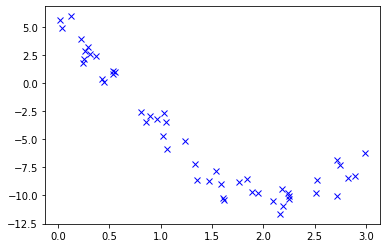

In [ ]:
x = 3 * random.rand(50) # between 0 and 3
e = 1 * random.randn(x.size) # noise
y = 10*cos(x+1) + e # cosine function plus some gaussian noise
plot(x,y,'bx')

array([ 2.48157224, -5.18157908])

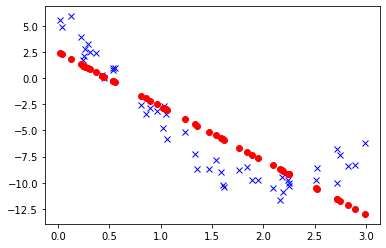

In [ ]:
# linear regression with f(x) = a + bx
X = np.ones((x.size, 2)) # we have 2 feature, first second is data itself
X[:, 1] = x
Xpinv = inv(X.T.dot(X)).dot(X.T)
beta = Xpinv.dot(y)
y_pred = X.dot(beta)
plot(x,y,'bx'); plot(x,y_pred,'ro'); beta

## Linear regression with higher dimension

array([  6.910769 , -15.1902933,   3.4698606])

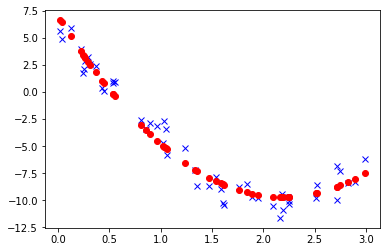

In [ ]:
# linear model f(x) = b0 + b1 x + b2 * x^2
X = np.ones((x.size,3));
X[:,1] = x # partials wrt. b1
X[:,2] = x*x # wrt. b2

# sames as before
Xpinv = inv(X.T.dot(X)).dot(X.T)
beta = Xpinv.dot(y)
y_pred = X.dot(beta)
plot(x,y,'bx'); plot(x,y_pred,'ro'); beta

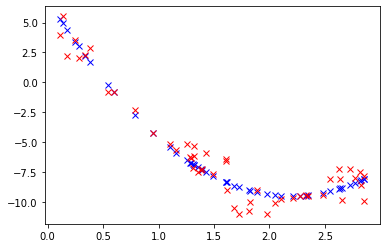

In [ ]:
# with sckit learn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge # similar thing except that it adds regularization
regressor = LinearRegression()
x = 3 * random.rand(100000)
e = 1 * random.randn(x.size) # noise
y = 10*cos(x+1) + e
X = np.ones((x.size, 3))
X[:, 1] = x
X[:, 2] = x*x
regressor.fit(X, y)

x_new = 3 * random.rand(50)
y_new_true =10*cos(x_new+1) + 1 * random.randn(x_new.size)
X_test = np.ones((x_new.size, 3))
X_test[:, 1] = x_new
X_test[:, 2] = x_new * x_new
y_pred = regressor.predict(X_test)
plot(x_new, y_pred, 'bx'); plot(x_new, y_new_true, 'rx')

# PCA

### Directions of Maximum Variance

- Let $X\in\mathbb{R}^N$ be a continuous random variable with $\mathbb{E}\left[X\right]=0$ mean and covariance matrix $C$. What is the direction of maximum variance?

> For any vector $a\in\mathbb{R}^N$
><br/><br/>
> $\displaystyle \mathbb{Var}[a^T X] = \mathbb{E}\left[(a^T X)(X^T a)\right] = \mathbb{E}\left[a^T(XX^T)\,a\right]$
><br/><br/>
> so
><br/><br/>
> $\displaystyle \mathbb{Var}[a^T X] = a^T\,\mathbb{E}\!\left[XX^T\right]\,a = a^T C\,a$
><br/><br/>
> We have to maximize this such that $a^2\!=\!1$

### Constrained Optimization
- **Lagrange multiplier**: extra term with new parameter $\lambda$

> $\displaystyle  \hat{a} = \arg\max_{a\in{}\mathbb{R}^N} \left[a^T C\,a - \lambda\,(a^2\!-\!1)\right]$

### Result

- The value of maximum variance is

> $\displaystyle  \hat{a}^TC\,\hat{a} = \hat{a}^T \lambda\,\hat{a} = \lambda\, \hat{a}^T\hat{a} = \lambda$
><br/><br/>
> the largest eigenvalue $\lambda_1$

- The direction of maximum variance is the corresponding eigenvector $a_1$

> $\displaystyle  Ca_1 = \lambda_1 a_1 $

- This is the **1st Principal Component**

### PCA

- Spectral decomposition or eigenvalue decomposition or eigendecomposition

> Let $\lambda_1\geq\lambda_2\geq\dots\geq\lambda_N\geq{}0$ be the eigenvalues of $C$ and ${e}_1,\dots,{e}_N$ the corresponding eigenvectors
><br/><br/>
> $\displaystyle  C = \sum_{k=1}^N\ \lambda_k\left({e}_k\,{e}_k^T\right) $
><br/><br/>
> Consider $\displaystyle C\,e_l = \sum_k \lambda_k\,e_k\left(e_k^T e_l\right) = \lambda_l\,e_l$ for any $l$

- Matrix form

> With diagonal $\Lambda$ matrix of the eigenvalues and an $E$ matrix of $[{e}_1, \dots, {e}_N]$
><br/><br/>
> $\displaystyle  C = E\ \Lambda\ E^T$


- The eigenvectors of largest eigenvalues capture the most variance

> If keeping only $K<N$ eigenvectors, the best approximation is taking the first $K$ PCs
><br/><br/>
> $\displaystyle  C \approx \sum_{k=1}^K\ \lambda_k\left({e}_k\,{e}_k^T\right) =  E_K\Lambda_KE_K^T$

- The $E$ matrix of eigenvectors is a rotation, $E\,E^T = I$

> $\displaystyle  Z = E^T\, X $


- A truncated set of eigenvectors $E_K$ defines a projection

> $\displaystyle  Z_K = E_K^T\, X $
><br/><br/>
> and
><br/><br/>
> $\displaystyle  X_K = E_K Z_K = E_K E_K^T\, X = P_K\,X $

### Samples

- Set of $N$-vectors arranged in matrix $X=\left[x_1, x_2, \dots, x_n \right]$ with average of 0 <br>
<font color="red">*This is NOT the random variable we talked about previously but the data matrix!*</font>

> Sample covariance matrix is
><br/><br/>
>$\displaystyle C = \frac{1}{n\!-\!1}\ X X^T = \frac{1}{n\!-\!1}\  \sum_i x_i x_i^T$

- Singular Value Decomposition (SVD)

>$\displaystyle X = U W V^T$
><br/><br/>
> where $U^TU=I$, $W$ is diagonal, and $V^TV=I$

- Hence

>$\displaystyle C = \frac{1}{n\!-\!1}\  UWV^T\ VWU^T = \frac{1}{n\!-\!1}\ U W^2 U^T$
><br/><br/>
> So, if $C=E\Lambda E^T$ then $E = U$ and $\displaystyle \Lambda = \frac{1}{n\!-\!1}\  W^2$








## PCA computed by eigenvectors and svd directly

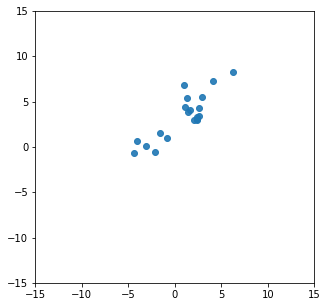

In [ ]:
from scipy.stats import norm
# generate multiple 2-D (column) vectors
S = norm.rvs(0,1,(2,20))
S[0,:] *= 4  # scale axis 0
f = +pi/4    # rotate by 45 degrees
R = array([[cos(f), -sin(f)],
           [sin(f),  cos(f)]])
X = R.dot(S)
X += np.array([[1],[3]]) # shift

figure(figsize=(5,5)); xlim(-15,15); ylim(-15,15);
plot(X[0,:],X[1,:],'o',alpha=0.9)

In [ ]:
Y = X.T
Y -= Y.mean(axis=0, keepdims=True)
Y.shape
C = (Y.T).dot(Y) / (Y.shape[0]-1)
eigenvalues, eigenvectors= np.linalg.eig(C)
n_components=1
idx = eigenvalues.argsort()[::-1]
print(idx)
eigenvalues = eigenvalues[idx][:n_components]
eigenvectors = eigenvectors[:, idx][:, :n_components]
Y_transform = Y.dot(eigenvectors)
print(eigenvectors)
print(Y_transform)
from sklearn import decomposition
pca = decomposition.PCA(n_components=n_components)
out = pca.fit_transform(Y)
print(out)

[0 1]
[[0.74192072]
 [0.67048762]]
[[ 0.78585855]
 [ 5.01008876]
 [-6.65229859]
 [ 0.60699428]
 [ 0.81749155]
 [ 2.93039788]
 [-5.15506174]
 [-5.54294461]
 [ 1.92544425]
 [ 1.05244238]
 [ 0.87357075]
 [ 1.25317938]
 [-2.88478401]
 [ 0.73854529]
 [ 0.98476584]
 [-3.0675917 ]
 [ 7.280863  ]
 [ 1.64744135]
 [-4.91781498]
 [ 2.31341236]]
[[ 0.78585855]
 [ 5.01008876]
 [-6.65229859]
 [ 0.60699428]
 [ 0.81749155]
 [ 2.93039788]
 [-5.15506174]
 [-5.54294461]
 [ 1.92544425]
 [ 1.05244238]
 [ 0.87357075]
 [ 1.25317938]
 [-2.88478401]
 [ 0.73854529]
 [ 0.98476584]
 [-3.0675917 ]
 [ 7.280863  ]
 [ 1.64744135]
 [-4.91781498]
 [ 2.31341236]]


In [ ]:
print(X.shape) # 2d gaussian, 20 examples
avg = np.mean(X, axis=1, keepdims=True)
X -= avg # zero mean
# covariance matrix
m =  (X[0,:].size-1)
C = X.dot(X.T) / (X.shape[1]-1)
print(C)

(2, 20)
[[8.09246442 7.79481668]
 [7.79481668 9.78569582]]


In [ ]:
L, E = np.linalg.eig(C) # L is eigen value and E is eigen vectors
num_eigen = L.shape[0]
diag_matrix = np.zeros((num_eigen, num_eigen))
diag_matrix[0, 0] = L[0]
diag_matrix[1,1] = L[1]
E @ diag_matrix @ E.T # recover covariance matrix

array([[8.09246442, 7.79481668],
       [7.79481668, 9.78569582]])

In [ ]:
# svd version
U, W, V = np.linalg.svd(X)
# U is the as E from eigenvector
print(U)
print(E)
# W^2 /N-1 is the same as eigenvalue
#print(W**2 / (X.shape[1]-1))
print(L)
temp = (W**2 /(X.shape[1]-1))
print(temp)

[[-0.66784069 -0.74430425]
 [-0.74430425  0.66784069]]
[[-0.74430425 -0.66784069]
 [ 0.66784069 -0.74430425]]
[ 1.09842165 16.77973859]
[16.77973859  1.09842165]


## PCA with sklearn

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=X.shape[0])
pca.fit(X.T) # different convention: row vs col !!!
pca.components_.T, pca.explained_variance_ # eigenvectors, eigenvalues in sorted version


(array([[ 0.66784069, -0.74430425],
        [ 0.74430425,  0.66784069]]), array([16.77973859,  1.09842165]))

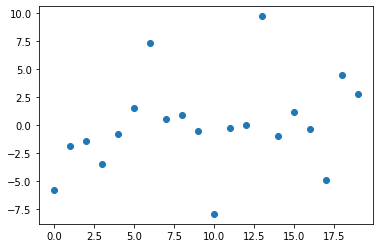

In [ ]:
# use learned pca to transform into lower dimension
pca = decomposition.PCA(n_components=1) # only keep the highest variance dimension
pca.fit(X.T)
pca.components_.T, pca.explained_variance_
x_trans = pca.transform(X.T)
idx = np.arange(0, x_trans.shape[0])
scatter(idx, x_trans)

### PCA application

#### Coordinate Transformation

- New covariance matrix is diagonal and the elements are the eigenvalues of $C$

> If $\beta=E^T X$ and again assuming $\mathbb{E}[X]=0$ then
><br/><br/>
> $\displaystyle \ \ \ \ \ \ \ \ \mathbb{E}[\beta \beta^T] = \mathbb{E}[E^T X\,X^T E] = E^T C\,E = \Lambda$
><br/><br/>
> where
><br/><br/>
>$\displaystyle \ \ \ \ \ \ \ \ \Lambda =  \left( \begin{array}{ccc}
{\lambda_1} & 0 & \cdots & 0\\
0 & {\lambda_2} &   & \vdots\\
\vdots &  & \ddots & 0 \\
0 & \cdots & 0 & {\lambda_N} \\
\end{array} \right)$

<!-- -->

> Recall $C\,\boldsymbol{e}_l = \lambda_l\,\boldsymbol{e}_l$ for all $l$, so the $(k,l)$ element of the new covariance matrix
><br/><br/>
>$\displaystyle \ \ \ \ \ \ \ \ \boldsymbol{e}_k^T C\,\boldsymbol{e}_l = \lambda_l\,\boldsymbol{e}_k^T  \boldsymbol{e}_l  = \lambda_l\delta_{kl} = \Lambda_{kl}$

#### Dimensionality Reduction


- A truncated set of eigenvectors $E_K$ defines a transformation that reduces the dimensionality from $N$ to $K$ while preserving the most variance possible

> $\displaystyle  \beta_K = E_K^T\, X $
><br/><br/>
> and
><br/><br/>
> $\displaystyle  X_K = E_K \beta_K = E_K E_K^T\, X = P_K\,X $




In [ ]:
%pylab inline
from scipy.stats import norm as gaussian
np.random.seed(42)
N = gaussian.rvs(0,1,(2,50))
# copy and scale it
S = np.copy(N)
S[0,:] *= 4  # scale axis 0
# rotate it
f = +pi/4    # rotate by 45 degrees
R = array([[cos(f), -sin(f)],
           [sin(f),  cos(f)]])
X = R.dot(S)
# shift it
X += np.array([[1],[3]])
print(X.shape)

Populating the interactive namespace from numpy and matplotlib
(2, 50)


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(2, 2) (2,)


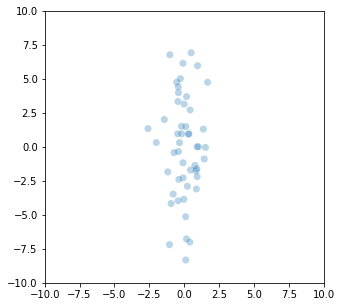

In [ ]:
avg = mean(X, axis=1).reshape(X[:,1].size,1)
X -= avg
# sample covariance matrix
C = X.dot(X.T) / (X.shape[1]-1)
L, E = np.linalg.eig(C)
print(C.shape, L.shape)
# rotation computed from EX, which is beta
A = E.T.dot(X);
figure(figsize=(5,5)); xlim(-10,10); ylim(-10,10);
scatter(A[0,:],A[1,:],marker='o',s=50,alpha=0.3,edgecolor='none');

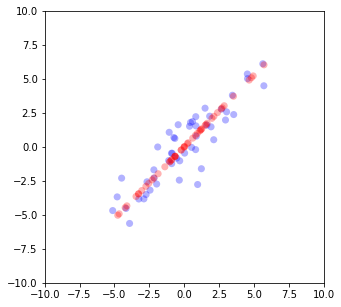

In [ ]:
# apply rotation matrix on data point
# project points
P = E[:,1:2].dot(E[:,1:2].T).dot(X)

figure(figsize=(5,5)); xlim(-10,10); ylim(-10,10);
scatter(X[0,:],X[1,:],marker='o',color='b', s=50, alpha=0.3, edgecolor='none');
scatter(P[0,:],P[1,:],marker='o',color='r', s=50, alpha=0.3, edgecolor='none');

### Data whiteninig with PCA

- Frequently used to preprocess data, e.g., in signal processing

>$ \displaystyle Z = \Lambda^{-1/2}\ E^T\ X$

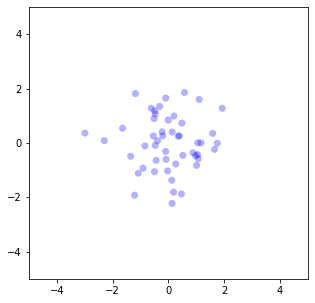

In [ ]:
# calc and plot whitened coordinates
B = diag(1/sqrt(L)).dot(A)
figure(figsize=(5,5)); xlim(-5,5); ylim(-5,5);
scatter(B[0,:],B[1,:], marker='o',color='b', s=50, alpha=0.3, edgecolor='none');

# Bayesian Inference

### Probabilitistic Model
- From data $D$ we can **infer** the parameters $\theta$ of model $M$

>$\displaystyle p(\theta \lvert D) = \frac{p(\theta)\,p(D \lvert \theta)}{p(D)}$
>
> or including the model $M$ explicitly
>
>
>$\displaystyle p(\theta \lvert D,M) = \frac{p(\theta \lvert M)\,p(D \lvert \theta,M)}{p(D \lvert M)}$

### Likelihood Function
- From data $D$ we can **infer** the parameters $\theta$ of model $M$

>$\displaystyle p(\theta \lvert D) = \frac{\pi(\theta)\,{\cal{}L}\!_D(\theta)}{Z}$
>
> where the normalization
>
>$\displaystyle Z = \int \pi(\theta)\,{\cal{}L}\!_D(\theta)\ d\theta $

- The **posterior** is proportional to the **prior** times the **likelihood function**



### Bayesian rule for posterior computation with different priors

0.10706183222045888

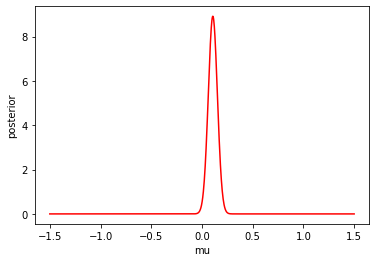

In [ ]:
data = np.random.randn(500) # fake data points from normal distribution
mu = np.linspace(-1.5,1.5,1000) # grid over the parameter

lk = np.exp(-0.5*np.sum(np.square(data-mu[:,newaxis]),axis=1))
pdf = lk / np.trapz(lk,mu) # Bayes' rule with improper prior 1 for theta

plot(mu,pdf,'r'); xlabel('mu'); ylabel('posterior');
np.trapz(mu*pdf,mu) # expectation value

In [ ]:
lk.shape

(1000,)

# Classification

### Classification Methods

- $k$-NN
- Naive Bayes
- Quadratic Discriminant Analysis
- Logistic regression
- Decisions trees
- Random forests
- Support Vector Machines

In [ ]:
# use iris dataset
from sklearn import datasets

iris = datasets.load_iris()

iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [ ]:
X = iris.data[:,:]
y = iris.target
X.shape, y.shape # 150 sample with 4 class

((150, 4), (150,))

### K Nearest Neighbor

In [ ]:
# sklearn version
from sklearn import neighbors

X = iris.data[:,:2] # using only 2 features for each
y = iris.target
clf = neighbors.KNeighborsClassifier(4)
clf.fit(X,y) # should split into train and test but ignore for simplicity
y_pred = clf.predict(X)
print("Number of mislabeled points out of a total %d points: %d"
      % (iris.target.size, (iris.target!=y_pred).sum()))

Number of mislabeled points out of a total 150 points: 25


In [ ]:
# implement from scratch
from heapq import *
num_sample = y.shape[0]
y_pred = np.zeros((X.shape[0]))
for i in range(num_sample):
    # find the closest k neighbors and use majority vote
    pivot = X[i, :]
    heap = []
    k = 10
    for j in range(num_sample):
        if i != j:
            # check distance and update heap
            # here we want botK instead of TopK so negate the distance to make it maxheap
            d = pivot - X[j, :]
            dist = d.dot(d)
            if len(heap) < k:
                heappush(heap, (-dist, j))
            else:
                heappushpop(heap, (-dist, j))

    # infer the label from the heap
    label_count = [0,0,0]
    for _, idx in heap:
        neighbor_cls = int(y[idx])
        label_count[neighbor_cls] += 1
    pred_label = np.argmax(np.array(label_count))
    y_pred[i] = pred_label
print(y_pred)
(iris.target!=y_pred).sum()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 2. 2. 2. 1. 2. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1.
 2. 1. 2. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 1. 2. 2. 1. 2. 0. 2. 1. 2. 2. 2. 1. 1. 1. 2. 1. 2. 2. 1.
 2. 1. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2. 1. 2.
 2. 1. 2. 1. 2. 1.]


31

## Naive Bayes

### Naive Bayes Classifier

- In general, we can use Bayes' rule (and law of total probability) to infer discrete classes $C_k$ for a given $\boldsymbol{x}$ set of features

>$\displaystyle P(C_k \lvert\,\boldsymbol{x}) = \frac{\pi(C_k)\,{\cal{}L}_{\!\boldsymbol{x}}(C_k)}{Z} $


- Naively assuming the features are independent

>$\displaystyle {\cal{}L}_{\!\boldsymbol{x}}(C_k) = \prod_{\alpha}^d p(x_{\alpha} \lvert C_k)$


### Naive Bayes: Learning

- Say for Gaussian likelihoods, we simply estimate the sample mean and variance of all features for each class $k$

>$\displaystyle p(x_{\alpha} \lvert C_k) = G(x_{\alpha};\mu_{k,\alpha}, \sigma^2_{k,\alpha})$

- We have to also pick some prior for the classes

> Using uniform or based on frequency of points in the training set?

### Naive Bayes: Estimation

- Look for maximum of the posterior


>$\displaystyle \hat{k} =  \mathrm{arg}\max_k \left[ \pi_k \prod_{\alpha}^d G(x_{\alpha};\mu_{k,\alpha}, \sigma^2_{k,\alpha})\right]$


In [ ]:
# calculate feature means and variances for each class
param = dict()  # we save them in this dictionary
data = iris.data.copy()
classes = np.unique(iris.target)

for k in classes:
    members = (iris.target == k) # boolean array
    num = members.sum()    # True:1, False:0
    prior = num / iris.target.size
    X = data[members,:] # slice out members
    mu = X.mean(axis=0)      # calc mean
    X -= mu
    var = (X*X).sum(axis=0) / (X.shape[0]-1)
    param[k] = (num, prior, mu, var) # save results

# init predicted values
k_pred = -1 * ones(iris.target.size)

# evaluate posterior for each point and find maximum
for i in range(iris.target.size):
    pmax, kmax = -1, None   # initialize to nonsense values
    for k in classes:
        num, prior, mu, var = param[k]
        diff = iris.data[i,:] - mu # multivariate normal distribution estimation
        d2 = diff*diff / (2*var) #
        p = prior * np.exp(-d2.sum()) / np.sqrt(np.prod(2*pi*var)) # denom is multiplied for each dimension
        if p > pmax:
            pmax = p
            kmax = k
    k_pred[i] = kmax

print("Number of mislabeled points out of a total %d points : %d"
      % (iris.target.size, (iris.target!=k_pred).sum()))

Number of mislabeled points out of a total 150 points : 6


In [ ]:
# sklearn way
# run sklearn's version - read up on differences if interested
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
print(iris.data.shape)
y_pred = gnb.fit(iris.data, iris.target).predict(iris.data)

print("Number of mislabeled points out of a total %d points : %d"
      % (iris.target.size, (iris.target!=y_pred).sum()))

(150, 4)
Number of mislabeled points out of a total 150 points : 6


## Quadratic Discriminant Analysis
> #### Best class?
>$\displaystyle \max_k \big[\ P(C_k|x)\ \big]$
>
>$\displaystyle \max_k \big[\ \pi_k {\cal{}L}_x(C_k)\ \big]$
>
>$\displaystyle \min_k \big[ -\ln\pi_k - \ln{\cal{}L}_x(C_k)\ \big]$

> #### Multivariate normal
>$\displaystyle {\cal{}L}_x(C_k) = \frac{1}{\sqrt{\lvert2\pi\Sigma_k\rvert}} \exp\left(-\frac{1}{2} (x\!-\!\mu_k)^T \Sigma_k^{-1} (x\!-\!\mu_k)\right)$
>
> Hence,
>
>$\displaystyle \min_k \Big[ \frac{1}{2} (x\!-\!\mu_k)^T \Sigma_k^{-1} (x\!-\!\mu_k) + \frac{1}{2}\ln\lvert\Sigma_k\rvert -\ln\pi_k \ \Big]$

In [ ]:
class MyQDA(object):
    """ Simple implementation for illustration purposes
    """
    def fit(self,X,C):
        self.param = dict()
        for k in np.unique(C):
            members = (C==k)
            prior = members.sum() / float(C.size)
            S = X[members,:] # subset of class
            mu = S.mean(axis=0)
            Z = (S-mu).T # centered column vectors
            cov = Z.dot(Z.T) / (Z[0,:].size-1)
            self.param[k] = (mu,cov,prior)
        return self

    def predict(self,Y):
        Cpred = -1 * np.ones(Y[:,0].size)
        for i in range(Cpred.size):
            d2min, kbest = 1e99, None
            for k in self.param:
                mu, cov, prior = self.param[k]
                diff = (Y[i,:]-mu).T
                d2 = diff.T.dot(np.linalg.inv(cov)).dot(diff) / 2
                d2 += np.log(np.linalg.det(cov)) / 2 - np.log(prior)
                if d2<d2min: d2min,kbest = d2,k
            Cpred[i] = kbest
        return Cpred

## Decision Tree

- Recursive partitioning of the training dataset

> At a given node with dataset $D$ we look for the
> best split
> <br>
> <br>
> $\theta = $ (feature $j$, threshold $t$)
> <br>
> <br>
> such that the
> partitions $D_{\textrm{left}}(\theta)$ and $D_{\textrm{right}}(\theta)$ have minimal *impurity*
> <br>
> <br>
> $\displaystyle I(\theta) = \frac{n_{\textrm{left}}}{n}\, H\Big(D_{\textrm{left}}(\theta)\Big) + \frac{n_{\textrm{right}}}{n}\,H\Big(D_{\textrm{right}}(\theta)\Big)$

- Different impurity functions $H(\cdot)$

> E.g., Gini with $K$ classes in the partition $D$
> <br>
> <br>
>$\displaystyle H(D) = \sum_{i=1}^K p_i (1-p_i)$
> <br>
> <br>
> Or variance for regression

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


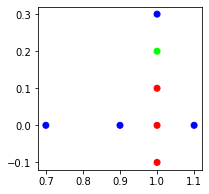

In [ ]:
# toy example
X = np.array([[.7,0],[1,.3],[1.1,0],[.9,0],[1,0],[1,-.1],[1,.1],[1,.2]],
             dtype=np.float)
c = np.array([ 0,0,0,0, 1,1,1, 2], dtype=np.float)
figure(figsize(3,3))
subplot(111,aspect='equal'); scatter(X[:,0],X[:,1],c=c,cmap=cm.brg);

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=1)
clf.fit(X,c)

print (clf.tree_.n_node_samples)
print (clf.tree_.impurity)
print (clf.tree_.feature)
print (clf.tree_.threshold)
print (clf.feature_importances_) # only X[0] matters in this case

[8 2 6]
[0.59375    0.         0.61111111]
[ 0 -2 -2]
[ 0.94999999 -2.         -2.        ]
[1. 0.]


### Gini impurity of a partition: Toy example

- We have 3 classes total hence the sum for the entire dataset is

>$ \displaystyle H = \frac{4}{8}\left(1\!-\!\frac{4}{8}\right)
     + \frac{3}{8}\left(1\!-\!\frac{3}{8}\right)
     + \frac{1}{8}\left(1\!-\!\frac{1}{8}\right) $ $ \displaystyle = \frac{16}{64}
     + \frac{15}{64}
     + \frac{7}{64}
     = \frac{19}{32} = 0.59375$
     
- This is the root of the tree

### Impurity of 2 partitions after first split

- The root partition contains 3 classes hence the sum is

>$ \displaystyle H_{\rm{}left} = \frac{2}{2}\left(1\!-\!\frac{2}{2}\right) + \frac{0}{2}\left(1\!-\!\frac{0}{2}\right) + \frac{0}{2}\left(1\!-\!\frac{0}{2}\right)= 0$

>$ \displaystyle H_{\rm{}right} = \frac{3}{6}\left(1\!-\!\frac{3}{6}\right)
     + \frac{2}{6}\left(1\!-\!\frac{2}{6}\right)
     + \frac{1}{6}\left(1\!-\!\frac{1}{6}\right) $

 $ \displaystyle = \frac{9}{36}
     + \frac{8}{36}
     + \frac{5}{36}
     = \frac{11}{18} $ $\approx 0.61111111$

> Cf. numbers above

- Note importance of weighting by partition sizes!

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)
clf.fit(X,c)

print (clf.tree_.n_node_samples)
print (clf.tree_.impurity)
print (clf.tree_.feature)
print (clf.tree_.threshold)
print (clf.feature_importances_) # so x[1] is a more important feature with more depth

[8 2 6 4 2]
[0.59375    0.         0.61111111 0.375      0.5       ]
[ 0 -2  1 -2 -2]
[ 0.94999999 -2.          0.15       -2.         -2.        ]
[0.48148148 0.51851852]


### Decision tree with Iris dataset

In [ ]:
# iris example
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:,:2].copy()  # only first 2 features
c = iris.target.copy()      # copy
subset = c<2 # classes 0 and 1
X,c = X[subset,:], c[subset]

print ('New classes:', np.unique(c))
print ('New data:', X.shape)

New classes: [0 1]
New data: (100, 2)


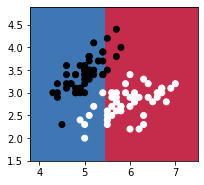

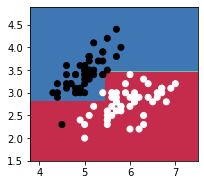

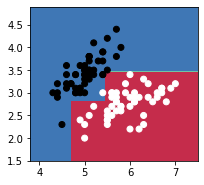

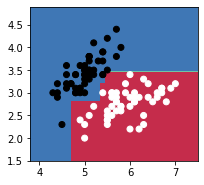

In [ ]:
# grid of points within the limits
h = 0.01
x,y = meshgrid(arange(X[:,0].min()-.5, X[:,0].max()+.5, h),
               arange(X[:,1].min()-.5, X[:,1].max()+.5, h))
grid = np.c_[x.ravel(),y.ravel()]

# decision-surfaces as fn of max depth
for depth in range(1,5):
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    z = clf.fit(X,c).predict(grid).reshape(x.shape)
    figure(figsize=(3,3)); subplot(111,aspect='equal')
    contourf(x, y, z, cmap=cm.Spectral_r)
    scatter(X[:,0], X[:,1], c=c, cmap=cm.gray);

## Random *Forest*

- Hard to pick the *best* in high dimensions (i.e., very expensive)

> Instead we pick a number of random directions to search<br/>
> and take the optimal split among those

- A randomized tree will not be optimal but much faster to build
- Then the forest combine the result by voting (boostrap and bagging)
- bagging: sample with replacement, data randomly selected by multiple models have equal weight
- boosting: sampling with updated weight based on how likely the data gives misclassified result. In evaluation stage, also might need to update weight scheme as test data comes in.

array([1. , 1. , 1. , 1. , 1. , 1. , 0.9, 1. , 0.9, 1. ])

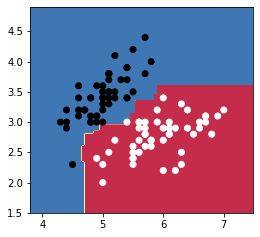

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators=50,max_depth=2)
z = clf.fit(X,c).predict(grid).reshape(x.shape)

figure(figsize=(4,4)); subplot(111,aspect='equal')
contourf(x,y,z, cmap=cm.Spectral_r)
scatter(X[:,0],X[:,1], c=c, cmap=cm.gray);

cross_val_score(clf, X,c, cv=10)

## Logistic Regression

### Recall linear regression
- General Form
> $ \displaystyle Y = X \beta + \epsilon $

- Fit (least square)
> $ \displaystyle \widehat{\beta} = (X^\top X)^{-1} X^\top Y $

- Predict
> $ \displaystyle \widehat{Y} = X \widehat{\beta} $

- Note that $ Y $ here is usually continuous. What if we have $ Y $ that is categorical, for example $ \displaystyle Y \in \{ 0, 1 \} $

### Binary Logistic Regression

- General Form
> $ \displaystyle \text{logit} \left[ \pi(x) \right] = \log \left[ \frac{\pi(x)}{1-\pi(x)} \right] = \beta_0 + \beta_1 x \qquad $ where $ \displaystyle \qquad \pi(x) = \mathbb{P}(y=1 \ | \ X = x) $

- Fit (maximum likelihood)
> $ \displaystyle \mathcal{L}(\beta_0, \beta_1) = \prod\limits_{i: y_i = 1} \pi(x_i; \beta_0, \beta_1) \prod\limits_{j: y_{j} = 0} [1 - \pi(x_j; \beta_0, \beta_1)] $
>
> $ \displaystyle l(\beta_0, \beta_1) = \log \mathcal{L}(\beta_0, \beta_1) = \sum_{i=1}^{n} \left[y_i \log \pi(x_i; \beta_0, \beta_1) + (1-y_i) \log(1-\pi(x_i; \beta_0, \beta_1)) \right] = \sum_{i=1}^{n} \left[y_i (\beta_0 + \beta_1 x_i) - \log (1 + \exp (\beta_0 + \beta_1 x_i))  \right] $
>
> $ \displaystyle \widehat{\beta}_0, \widehat{\beta}_1 = \arg \max_{\beta_0, \beta_1} l(\beta_0, \beta_1) $

- Predict
- What is the relationship between logit and probability?
> $ \displaystyle \text{logit}(p) = \log \left( \frac{p}{1-p} \right) \quad \Longrightarrow \quad e^{\text{logit}(p)} = \frac{p}{1-p} \quad \Longrightarrow \quad p = \frac{e^{\text{logit}(p)}}{1+e^{\text{logit}(p)}} $
- Thus
> $ \displaystyle \widehat{\pi}(x) = \frac{\exp \left( \widehat{\beta}_0 + \widehat{\beta}_1 x \right)}{1 + \exp \left( \widehat{\beta}_0 + \widehat{\beta}_1 x \right) } $

- Use negative loglikelihood to train because MSE gives non-convex training objective. In sklearn, it adds regularization

> $ \displaystyle \min_{\omega, c} \frac{1}{2} \omega^\top \omega + C \sum_{i=1}^{n} \log \left[ \exp \left( -y_i \left( X_i^\top \omega + c \right) \right) + 1 \right] \qquad L_2 \text{-regularization} $
>
> $ \displaystyle \min_{\omega, c} \lvert\lvert \omega \rvert\rvert_1 + C \sum_{i=1}^{n} \log \left[ \exp \left( -y_i \left( X_i^\top \omega + c \right) \right) + 1 \right] \qquad L_1 \text{-regularization} $

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Features:  (100, 1)
Target:  (100,)


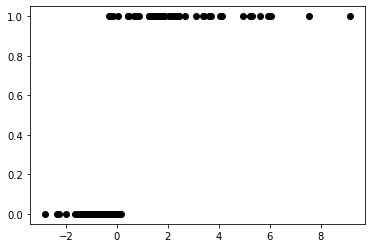

In [ ]:
# sigmoid func's derivative
#return sigmoid(x) * (1 - sigmoid(x))
# \sigmoid(\sum w_i x_i + b) gredient against w_i is: (y-y*)sigmoid_prime(\sum w_i x_i + b) x_i
# Generate data
n_samples = 100
np.random.seed(2018)

x = np.random.normal(size=n_samples)
y = (x > 0).astype(np.float)
x[x > 0] *= 4
x += .3 * np.random.normal(size=n_samples)
x = x[:, np.newaxis]

print('Features: ', x.shape)
print('Target: ', y.shape)
scatter(x, y, color='black');

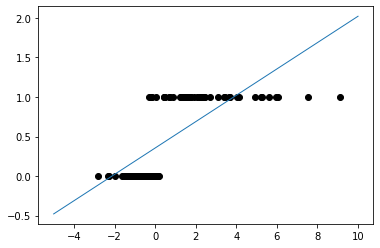

In [ ]:
# fit linear regression, works poorly
XX = np.ones((x.shape[0], 2))
XX[:,1] = x[:,0]
bHat = inv(XX.T.dot(XX)).dot(XX.T).dot(y)
b0, b1 = bHat
X_test = np.linspace(-5, 10, 300)

plot(X_test, b0 + b1 * X_test, linewidth=1);
scatter(x, y, color='black');

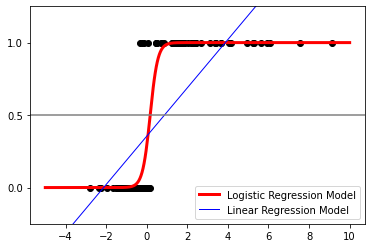

In [ ]:
# fit logistic regression
from sklearn.linear_model import LogisticRegression
# Fit a logistic regression model
clf = LogisticRegression(C=1e5) # Inverse of regularization strength.
clf.fit(x, y)
def Sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Predict
prob = Sigmoid(clf.intercept_ + clf.coef_ * X_test).ravel()

# Plot the result
plot(X_test, prob, color='red', linewidth=3)
plot(X_test, b0 + b1 * X_test, color='blue', linewidth=1);
scatter(x, y, color='black');
axhline(0.5, color='0.5');
ylim(-0.25, 1.25);
yticks([0, 0.5, 1]);
legend(('Logistic Regression Model', 'Linear Regression Model'), loc='lower right');

## SVM

- Linearly separable
> Let $ S_0 $ and $ S_1 $ be two sets of points in an $ n $-dimensional Euclidean space. We say $ S_0 $ and $ S_1 $ are linearly separable if $ \quad \exists w_1, w_2, \cdots, w_n, k \quad $ such that $ \qquad \forall x \in S_0 $, $ \displaystyle \sum_{i=1}^{n} w_i x_i > k \quad $ and $ \quad \forall x \in S_1 $, $ \displaystyle \sum_{i=1}^{n} w_i x_i < k \quad $ where $ x_i $ is the $ i $-th component of $ x $.

- Data
> $ \displaystyle \{(\mathbf{x}_i, y_i) \}_{i=1}^{n} \qquad $ where $ \displaystyle \qquad \mathbf{x}_i \in \mathbb{R}^d, \  y_i \in \{-1, 1 \} $

- Linearly separable if
> $ \displaystyle \exists (\mathbf{w}, b) \quad $ such that $ \displaystyle \quad y_i = \text{sign} \left(\langle \mathbf{w}, \mathbf{x}_i \rangle + b \right) \quad \forall i $
>
> $ \displaystyle \exists (\mathbf{w}, b) \quad $ such that $ \displaystyle \quad y_i \left(\langle \mathbf{w}, \mathbf{x}_i \rangle + b \right) > 0 \quad \forall i $

- Margin
> The margin of a hyperplane w.r.t training data is the minimal distance between a point in the training data and the hyperplane.
>
> In this sense, if a hyperplane has a large margin, then it still could separate the training data even if we slightly perturb each data point.

- Recall
> The distance between a point $ \mathbf{x} $ and the hyperplane defined by $ \quad (\mathbf{w}, b) \quad $ where $ \quad \lvert\lvert \mathbf{w} \rvert\rvert = 1 \quad $ is $ \quad \lvert \langle \mathbf{w}, \mathbf{x} \rangle + b \rvert $

- **Hard-SVM**: Fit a hyperplane that separates the training data with the largest possible margin
> $ \displaystyle \min_{\mathbf{w}, b} \ \lvert\lvert \mathbf{w} \rvert\rvert^2 \quad $ such that $ \displaystyle \quad y_i(\langle \mathbf{w}, \mathbf{x}_i \rangle + b) > 1 \quad \forall i $

- **Soft-SVM**: Relax the condition
> $ \displaystyle \min_{\mathbf{w}, b, \zeta} \lambda \lvert\lvert \mathbf{w} \rvert\rvert^2 + \frac{1}{n} \sum_{i=1}^{n} \zeta_i \qquad $ such that $ \displaystyle \quad y_i(\langle \mathbf{w}, \mathbf{x}_i \rangle + b) \ge 1 - \zeta_i \quad $ where $ \displaystyle \quad \lambda > 0, \  \zeta_i \ge 0 $

- Some kernels
> Polynomial kernel: $ \displaystyle \qquad K(x, x^\prime) = \left(1 + \langle x, x^\prime \rangle \right)^d $
>
> (Gaussian) radial basis function kernel (RBF): $ \displaystyle \qquad K(x, x^\prime) = \exp \left(- \frac{\lvert\lvert x - x^\prime \rvert\rvert^2}{2 \sigma^2} \right) = \exp (- \gamma \lvert\lvert x - x^\prime \rvert\rvert^2) \qquad $ where $ \displaystyle \qquad \gamma = \frac{1}{2 \sigma^2} $
>
>

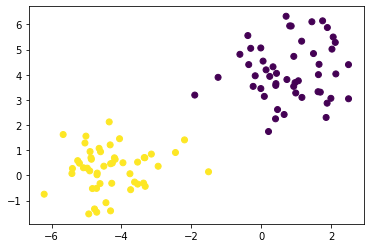

In [ ]:
from sklearn import svm
import pandas as pd
from sklearn import datasets
# Generate 100 separable points
x, y = datasets.make_blobs(n_samples=100, centers=2, random_state=3)
scatter(x[:,0], x[:,1], c=y);

(900, 2)


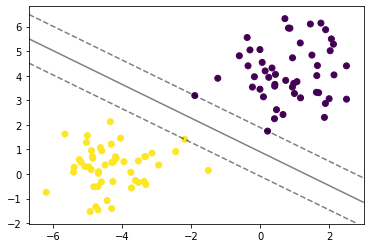

In [ ]:
# Fit SVM
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(x, y)
xx = np.linspace(x[:,0].min()-0.5, x[:,0].max()+0.5, 30)
yy = np.linspace(x[:,1].min()-0.5, x[:,1].max()+0.5, 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
print(xy.shape) # all possible points in this grid
Z = clf.decision_function(xy).reshape(XX.shape) # map each x,y point
contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--']);
scatter(x[:,0], x[:,1], c=y);

## Clustering
### Types of Algorithms
- Flat

>1. Start with a random partitioning
>2. Iterate to improve the grouping

- Hierarchical

>1. Greedy grouping of closest: bottom up
>2. Greedy splitting of farthest: top down

### K-means clustering

### Optimization

- Formally, it's an optimization over the possible groupings of objects

> For a set of $\{ x_l \}$ where $x_l\in \mathbb{R}^d$ for all $l$
><br>
><br>
>$\displaystyle  \hat{{C}} = \textrm{arg}\min_{{C}} \sum_{i=1}^k \left[\ \sum_{x\in{}C_i}\ \lvert\!\lvert x-\mu_i\rvert\!\rvert^2 \right] $
><br>
><br>
> where
><br>
><br>
>$\displaystyle  \mu_i = \frac{1}{\lvert{C_i}\rvert}\sum_{x\in{}C_i} x $

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


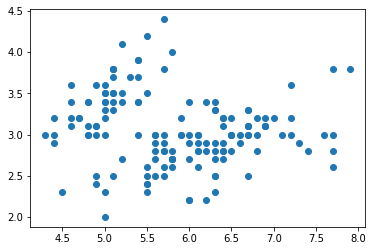

In [ ]:
%pylab inline
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:,:2]
# only the first 2 features

scatter(X[:,0],X[:,1]);

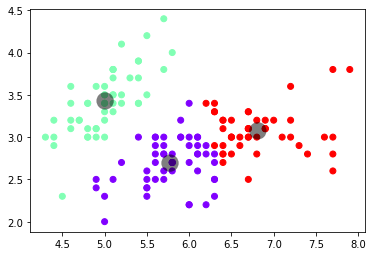

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='random', n_clusters=3, n_init=100)
kmeans.fit(X)

figure(figsize=(6,6)); ax=subplot(aspect='equal')
scatter(X[:,0],X[:,1],c=kmeans.labels_,cmap=cm.rainbow);

C = kmeans.cluster_centers_
scatter(C[:,0],C[:,1],c='k',marker='o',s=300,alpha=0.5,edgecolor='none');

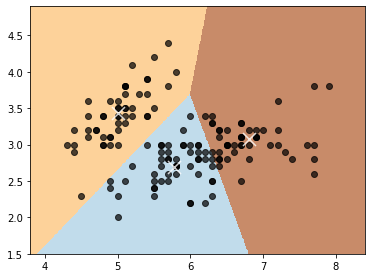

In [ ]:
# Step size of the mesh.
h = .005    # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X[:, 0].min() -.5, X[:, 0].max() +.5
y_min, y_max = X[:, 1].min() -.5, X[:, 1].max() +.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
P = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
P = P.reshape(xx.shape)
figure(figsize=(6,6)); subplot(111,aspect='equal')
plt.clf()

plt.imshow(P, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='equal', origin='lower', alpha=0.7)

plt.scatter(X[:, 0], X[:, 1], c='k', alpha=0.7)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10, alpha=0.8)

plt.xlim(x_min, x_max);
plt.ylim(y_min, y_max);

In [ ]:
# kmeans from scratch
iris = datasets.load_iris()
X = iris.data[:,:2]
num_samples = X.shape[0]
k = 3
# randomly pick 3 sample from X as pivots
centers = np.random.choice(num_samples, k)
centroids = [X[center, :] for center in centers]
assignments = np.zeros((num_samples, ))
it = 0
while it < 10:
    for i in range(num_samples):
        cur_data = X[i, :]
        closest = np.inf
        cluster_id = -1
        for center_idx, pivot in enumerate(centroids):
            dist = np.sum(np.square(cur_data - pivot))
            if dist < closest:
                closest = dist
                cluster_id = center_idx
        assignments[i] = cluster_id
    # compute new center
    for center in [_ for _ in range(k)]:
        group = X[(assignments == center)]
        centroids[center] = group.mean(axis=0)
    print(centroids)
    it += 1

[array([4.9877551 , 3.06326531]), array([5.495, 3.705]), array([6.44691358, 2.89382716])]
[array([5.036, 2.972]), array([5.35714286, 3.74285714]), array([6.4835443 , 2.92911392])]
[array([5.08979592, 2.89591837]), array([5.268, 3.704]), array([6.51842105, 2.94868421])]
[array([5.2  , 2.818]), array([5.19666667, 3.66      ]), array([6.58, 2.97])]
[array([5.21914894, 2.78510638]), array([5.16969697, 3.63030303]), array([6.58, 2.97])]
[array([5.28333333, 2.73571429]), array([5.10526316, 3.57368421]), array([6.58, 2.97])]
[array([5.445 , 2.6725]), array([5.04318182, 3.50454545]), array([6.61818182, 2.99242424])]
[array([5.58974359, 2.64102564]), array([5.01632653, 3.45102041]), array([6.65645161, 3.00806452])]
[array([5.65      , 2.64772727]), array([5.01632653, 3.45102041]), array([6.70350877, 3.03508772])]
[array([5.70408163, 2.66122449]), array([5.01632653, 3.45102041]), array([6.75384615, 3.05961538])]


## Gaussian Mixtrue Models

- A probabilistic approach to clustering

> Infer the parameters of $k$ **components**

- For example, a mixture of two Gaussians ($k\!=\!2$)

> **Parameters** $\boldsymbol{\theta}$ are $(\mu_1,\Sigma_1),\ (\mu_2,\Sigma_2)$ and the<br>
> cluster membership probabilities $\boldsymbol{\kappa}$
- Difficult because of the unknown cluster memberships $\boldsymbol{\kappa}$

## GMM with k=2

> $\kappa_i$ is the probability of that $x_i$ belongs to component 1 <br>
> $(1\!-\!\kappa_i)$ is the prob of belonging to component 2

- Likelihood function

>$\displaystyle L(\boldsymbol{\theta};\boldsymbol{x}) = \prod_{i=1}^n \Big[ \kappa_i\, G\left(x_i;\mu_1,\Sigma_1\right) + (1\!-\!\kappa_i)\, G\left(x_i; \mu_2,\Sigma_2\right)\Big]$

## Expectation-Maximization Algorithm

- The EM algorithm is a general framework

>1. Create an initial model $\theta$
>2. Find a better $\theta'$ s.t. <br>
> the likelihood improves: $p(D\mid\theta') > p(D\mid\theta)$ <br/>
> (or the posterior)
>3. Repeat until convergence

## E-step

- Estimate the membership probabilities $\boldsymbol{\kappa}$

> Based on the current model $(\mu_1,\mu_2,\Sigma_1,\Sigma_2)$ and data $\boldsymbol{x}$

## M-step

- Maximize the likelihood function  

> Based on the estimated membership probabilities $\boldsymbol{\kappa}$, obtain better $(\mu_1,\mu_2,\Sigma_1,\Sigma_2)$ estimates

- In spirit, this is not completely unlike $k$-means clustering algorithm

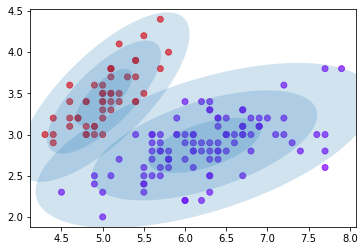

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn import datasets
from matplotlib.patches import Ellipse

iris = datasets.load_iris()
X = iris.data[:,:2] # only 2 features

gmm = GaussianMixture(n_components=2)
gmm.fit(X)
Cpred = gmm.predict(X)

ax = subplot(111, aspect='equal')
scatter(X[:,0], X[:,1], c=Cpred, cmap=cm.rainbow, alpha=0.7)
# visualization of the two components (gaussian)
for n in arange(gmm.n_components):
    cov = gmm.covariances_[n][:2,:2]
    v, w = np.linalg.eigh(cov)
    angle = 180/pi * arctan2(w[0,1],w[0,0])
    for i in range(1,4): # of contours
        a = 2*i*np.sqrt(v)
        ell = Ellipse(gmm.means_[n,:2], a[0],a[1], angle)
        ell.set_alpha(0.2)
        ax.add_artist(ell)

# Others

## Sparse matrix with row reduce formation or colum reduce format

In [ ]:
import numpy as np

In [ ]:
class SparseMatrix:
    def __init__(self, row, column):
        self.r, self.c = row, column
        max_ele = 100 # hardcode
        self.M = np.zeros((max_ele, 3))
        self.len = 0

    def insert(self, i, j, val):
        self.M[self.len][0] = i
        self.M[self.len][1] = j
        self.M[self.len][2] = val
        self.len += 1

    def multiply(self, other):
        # perform transpose of other first
        other_T = other.transpose()
        out = SparseMatrix(self.r, self.c)
        for i in range(self.len):
            row_idx, col_idx, x_val = self.M[i][0], self.M[i][1], self.M[i][2]
            for j in range(other_T.len):
                other_row_idx, other_col_idx, y_val = other_T.M[j][0], other_T.M[j][1], other_T.M[j][2]
                if col_idx == other_col_idx: # corresponding entry in two matrix
                    out.insert(row_idx, other_row_idx, x_val*y_val)
        return out


    def transpose(self):
        for i in range(self.len):
            temp = self.M[i][0]
            self.M[i][0] = self.M[i][1]
            self.M[i][1] = temp
        return self

    def __str__(self) -> str:
        return str(self.M[:self.len, :])




In [ ]:
sm1 = SparseMatrix(4,4)
sm1.insert(1,2, 10)
sm1.insert(1,4, 12)
sm1.insert(3,3, 5)
sm1.insert(4,1, 15)
sm1.insert(4,2, 12)
print(sm1)

sm2 = SparseMatrix(4,4)
sm2.insert(1,3, 8)
sm2.insert(2,4, 23)
sm2.insert(3,3, 9)
sm2.insert(4,1, 20)
sm2.insert(4,2, 25)
print(sm2)


result = sm1.multiply(sm2)
print(result)

[[ 1.  2. 10.]
 [ 1.  4. 12.]
 [ 3.  3.  5.]
 [ 4.  1. 15.]
 [ 4.  2. 12.]]
[[ 1.  3.  8.]
 [ 2.  4. 23.]
 [ 3.  3.  9.]
 [ 4.  1. 20.]
 [ 4.  2. 25.]]
[[  1.   4. 230.]
 [  1.   1. 240.]
 [  1.   2. 300.]
 [  3.   3.  45.]
 [  4.   3. 120.]
 [  4.   4. 276.]]


## Sorting

### Quick Sort

In [ ]:
import random
def sortArray(nums):
    # quicksort
    quicksort(nums, 0, len(nums)-1)
    return nums

def quicksort(nums, l, r):
    # p is the point that we partition the array
    if r <= l:
        return
    p = random.randint(l, r)
    # swap p to the left
    nums[p],  nums[l] = nums[l], nums[p]
    pivot = nums[l]
    j = l
    for i in range(l + 1, r + 1):
        if nums[i] < pivot:
            j += 1
            #swap the value in these index
            nums[i], nums[j] = nums[j], nums[i]

    nums[l], nums[j] = nums[j], nums[l]
    # j is the partition index and we perform quicksort separated by j
    quicksort(nums, l, j-1)
    quicksort(nums, j+1, r)

x = [1,3,4,2,5,9,8,20,7]
sortArray(x)

[1, 2, 3, 4, 5, 7, 8, 9, 20]

### merge sort

In [ ]:
def sortArray(nums):
    return mergesort(nums)

def mergesort(part):
    # reached the bottom, base case
    n = len(part)
    if n < 2:
        return part
    if n == 2:
        if part[0] < part[1]:
            return part
        else:
            part.reverse()
            return part
    mid = n // 2
    # divide and conquer, each temp is expected to be a sort array
    temp1 = mergesort(part[:mid])
    temp2 = mergesort(part[mid:])

    # merge the two array sorted above
    res = []
    idx1, idx2 = 0, 0
    while idx1 < len(temp1) and idx2 < len(temp2):
        if temp1[idx1] < temp2[idx2]:
            res.append(temp1[idx1])
            idx1 += 1
        else:
            res.append(temp2[idx2])
            idx2 += 1
    # always check if there is remaining stuff in either list
    while idx1 < len(temp1):
        res.append(temp1[idx1])
        idx1 += 1
    while idx2 < len(temp2):
        res.append(temp2[idx2])
        idx2 += 1
    return res

x = [1,3,4,2,5,9,8,20,7]
sortArray(x)

[1, 2, 3, 4, 5, 7, 8, 9, 20]

## Searching

In [ ]:
# binary search, most common approach used
def search(nums, target):
    start = 0
    end = len(nums)-1
    while start <= end:
        mid = start + (end - start)//2 # equivalent of floor operation
        if nums[mid] == target:
            return mid
        elif nums[mid] < target:
            start = mid + 1
        else:
            end = mid - 1
    return -1

In [ ]:
# square root can be thought of a binary search, where we check the mid*2
def mySqrt(x: int) -> int:
    small = 0
    large = x

    while small <= large:
        mid = small + (large - small)//2
        if mid*mid == x:
            return mid
        elif mid*mid < x:
            small = mid + 1
        else:
            large = mid - 1
    return small - 1

# power operation is the same
def myPow(x, n):
    if n == 1: return x
    if n == 0: return 1
    if n < 0: return myPow(1/x, -1*n)
    if n % 2 == 1: return x*myPow(x, n-1)
    return myPow(x*x, n/2)
myPow(2, -3)

0.125

## List, reverse nodes in k groups

In [ ]:
# first define node class
class ListNode:
    def __init__(self, next=None, val=0):
        self.next = next
        self.val = val

    def __str__(self):
        vals = []
        cur = self
        vals.append(cur.val)
        while cur.next is not None:
            cur = cur.next
            vals.append(cur.val)
        return str(vals)


def reverseKGroup(head, k):
    # as long as we have k elements left,  we reverse them
    if not head: return head
    # iterate through to check how many nodes we have
    count = 0
    cur = head
    while cur:
        count+=1
        cur = cur.next

    itr = count // k
    sentinal = ListNode(next=head)
    cur = sentinal
    while itr != 0:
        itr -= 1
        # reverse k nodes from cur to cur+k
        cur = reverse_node(cur,  k)
    return sentinal.next

def reverse_node(node, k):
    # sps we have 2->3->4, k=2, we want it become 4->3-2
    begin = node # begin is initialized to be 2
    cur = begin.next.next # 4
    prev = begin.next # 3
    while k > 1:
        next = cur.next # None
        cur.next = prev # 4->3, connect backward
        prev = cur # prev=4, for next update
        cur = next # cur=None
        k -= 1
    output = begin.next # begin is 2, begin's next is still 3
    output.next = cur # 3->None
    begin.next = prev # 2->4, now we have 2->4->3->None
    return output

# we want to reverse every k node in the list
start = ListNode(val=0)
ele1 = ListNode(val=1)
start.next = ele1
ele2 = ListNode(val=2)
ele1.next = ele2
ele3 = ListNode(val=3)
ele2.next = ele3
ele4 = ListNode(val=4)
ele3.next = ele4
print(start) # 0->1->2->3->4
reverse_start = reverseKGroup(start, 2)
print(reverse_start) # 1->0->3->2->4, every other 2 nodes are swapped

[0, 1, 2, 3, 4]
[1, 0, 3, 2, 4]


In [ ]:
# fast and slow pointers to find cycle
def hasCycle(self, head: ListNode) -> bool:
    slow, fast = head, head
    # if fast is null before it reaches the slower one
    while fast and fast.next:
        slow = slow.next
        fast = fast.next.next
        if slow == fast:
            return True
    return False

def detectCycle(self, head: ListNode) -> ListNode:
    # we first need to find out the meeting point
    slow, fast, start = head, head, head
    # if fast is null before it reaches the slower one
    while fast and fast.next:
        slow = slow.next
        fast = fast.next.next
        if slow == fast:
            # after slow and fast pointer meet, we get a new pointer at the start
            # start to move both start and slow pointer unti they meet
            while start != slow:
                start = start.next
                slow = slow.next
            return start
    return None

## Two Pointers

In [ ]:
def maxSubArray(self, nums):
    # we take a slice a subarray and compute its sum from the start
    # solution is O(N)
    prev_sum, largest_sum = nums[0], nums[0]
    for i in range(1, len(nums)):
        cur_num = nums[i]
        if prev_sum < 0:
            # always replace with current value since negative value has no use
            prev_sum = cur_num
            if prev_sum > largest_sum:
                largest_sum = prev_sum
        else:
            prev_sum += cur_num
            # update largest sum
            if prev_sum > largest_sum:
                largest_sum = prev_sum
    return largest_sum

In [ ]:
def totalFruit(self, tree):
    # reframe the question: we are trying to find maxlen of subarray with at most 2 distinct values
    # it's common to track two pointers moving from left together so it's O(N),
    # if we go from different side, then it's O(N^2) that checks all possible subarray
    fruits = []
    left, right, max_fruit = 0, 0, 0
    fruits.append(tree[0])
    for i in range(1, len(tree)):
        if tree[i] in fruits:
            fruits.append(tree[i])
        else:
            # fruit set already has 2 kinds of fruit
            while (len(set(fruits)) == 2):
                left += 1
                fruits.pop(0)
            fruits.append(tree[i])
        right = i
        if right - left > max_fruit:
            max_fruit = right - left
    return max_fruit + 1

## Graph Algorithm

### Dijkstra's algorithm

In [ ]:
def networkDelayTime(times, N, K):
    graph = collections.defaultdict(list)
    for u, v, w in times:
        graph[u].append((v, w))
    # heap queue implementation
    pq = [(0, K)]
    dist = {}
    while pq: # traverse all edges O(E)
        # log(V) operation for pop and push
        # Complexity is O(ElogV)
        d, node = heapq.heappop(pq)
        if node in dist: continue # already visited node
        dist[node] = d
        for nei, d2 in graph[node]:
            if nei not in dist:
                heapq.heappush(pq, (d+d2, nei))

    return max(dist.values()) if len(dist) == N else -1 # -1 means not able to reach all node

### Binary Tree BFS

In [ ]:
  # Breadth First Search that traverse through each level
  def levelOrder(root: TreeNode):
      queue = []
      if not root:
          return []
      queue.append(root)
      output = [[root.val]]
      # need a second queue because we need to pop out the current one for the whole level
      while queue:
          temp = []
          temp_queue = []
          for top in queue:
              if top.left:
                  temp_queue.append(top.left)
                  temp.append(top.left.val)
              if top.right:
                  temp_queue.append(top.right)
                  temp.append(top.right.val)
          queue = temp_queue
          if len(temp) > 0:
              output.append(temp)
  return output

In [ ]:
# in grid representation, a common trick to use is to search nearby points by dx, dy
def orangesRotting(grid):
    while queue:
        day += 1
        # start making other oranges rotton
        for i,j in queue:
            for dx, dy in [(1,0), (-1,0), (0,1),(0,-1)]:
                if 0 <= i+dx < row and 0<=j +dy < col and (not visited[i+dx][j+dy]):
                    # new rotton oranges
                    if grid[i+dx][j+dy] == 1:
                        # temp is the next traversal (next level in BST)
                        temp.append((i+dx, j+dy))
                        visited[i+dx][j+dy] = True
                        # the position is rotton now
                        grid[i+dx][j+dy] = 2
        queue = temp
        temp = []

    return day-1 if self.get_visited(visited) == total else -1

### DFS

In [ ]:
# classical path sum algorithm
def hasPathSum(self, root: TreeNode, sum: int) -> bool:
    return self.DFS(root, sum)

def DFS(self, node: TreeNode, left: int) -> bool:
    # check we reach a leaf
    if not node:
        return False
    if not node.left and not node.right:
        return True if left - node.val == 0 else False

    # check left subnode and right subnode
    return self.DFS(node.left, left-node.val) or self.DFS(node.right,left-node.val)

In [ ]:
# path sum II (with backtracking to find all root-to-leaf paths)
def pathSum(self, root: TreeNode, sum: int) -> List[List[int]]:
    output = []
    temp = []
    self.DFS(root, sum, output, temp)
    return output
def DFS(self, node: TreeNode, left: int, output: List, temp: List):
    if not node:
        return False
    if not node.right and not node.left:
        # we reach the leaf
        if left - node.val == 0:
            temp.append(node.val)
            output.append(temp.copy()) # find one legit path
            temp.pop() # might has other legit path, pop the added val just like backtrackking
    # case 1: not reach leaf so we directly append the value
    # case 2: reach leaf and already found the path, we still add val back and next it we return False
    # case 3: reach leaf and didn't pass the sum check, doesn't matter if we append here or not
    temp.append(node.val)  # so really this is only meaningful in case 1
    self.DFS(node.left, left-node.val, output, temp)
    self.DFS(node.right, left-node.val, output, temp)
    # this node shouldnt be in temp after both children are checked
    temp.pop()

In [ ]:
# longest path in DAG:
def dfs(node, adj, dp, vis):
    # Mark as visited
    vis[node] = True
    # Traverse for all its children
    for i in range(0, len(adj[node])):
        # If not visited
        if not vis[adj[node][i]]:
            dfs(adj[node][i], adj, dp, vis)

        # Store the max of the paths
        # 1+adj node's length compared with cur position's length
        dp[node] = max(dp[node], 1 + dp[adj[node][i]])

### Topological Sort

In [ ]:
# sorting method for DAG, goes from node that has no parent
def canFinish(numCourses, prerequisites):
    # have a map, key is course num, val is num of prereqs
    m = [[] for _ in range(numCourses)]
    prereq = [0 for _ in range(numCourses)]
    for item in prerequisites:
        m[item[1]].append(item[0]) # item1->item0
        prereq[item[0]] += 1
    start = []
    visited = [False for _ in range(numCourses)]
    for i in range(len(prereq)):
        if prereq[i] == 0: # no prereq for the class
            start.append(i)
            visited[i] = True # visit here might not be necessary if it's DAG

    n = 0
    while start:
        top = start.pop()
        n += 1
        for item in m[top]: # for all class that top is a prereq
            prereq[item] -= 1
            if prereq[item] == 0 and not visited[item]:
                start.append(item)
                visited[item] = True
    return n == numCourses

## Hashmap implementation

In [ ]:
class ListNode(object):
    def __init__(self, key):
        self.key = key
        self.val = None
        self.next = None

# double chaining implementation with a linkedlist for each hash_id
class MyHashMap:
    SIZE = 1000

    def __init__(self):
        # pre-set hash size
        self.hashing = [ListNode(-1) for _ in range(self.SIZE)]

    def put(self, key: int, value: int) -> None:
        # first compute the hash key to obtain the linkedlist's head
        # if using hash table with linear/quadratic probing, then there is no
        # linked list but need to shift the key
        head = self.hashing[key % self.SIZE]
        current = head.next
        while current:
            # overwrite value for existing key
            if current.key == key: break
            current = current.next
        else:
            # append a new key
            current = ListNode(key)
            current.next = head.next
            head.next = current
        current.val = value

    def get(self, key: int) -> int:
        current = self.hashing[key % self.SIZE].next
        while current:
            if current.key == key: break
            current = current.next
        else:
            # no such key exist in the linked-list
            return -1
        return current.val

    def remove(self, key: int) -> None:
        current = self.hashing[key % self.SIZE]
        while current and current.next:
            if current.next.key == key: break
            # overwrite the link
            current = current.next
        else:
            # else block is reached after while loop is exhausted and break
            # condition is not reached
            return None
        # reach here means break is triggered and next key is the key to remove
        current.next = current.next.next

## Greedy Approach

In [ ]:
# jump games
def canJump(self, nums: List[int]) -> bool:
    n = len(nums)
    end = nums[0]
    for i in range(n):
        if i <= end:
            # always jump when we can
            end = max(i+nums[i], end)
    if end >= n-1:
        return True
    else:
        return False

# jump game II, compute number of jump to reach end, if reachable
# O(N^2) for DP approach
def jump(self, nums: List[int]) -> int:
    n = len(nums)
    dp = [float('inf') for _ in range(n)]
    dp[0] = 0
    for i in range(n):
        # we update the jumps from current location i
        if dp[i] != float('inf'):
            # we can reach ith position
            for j in range(i+1, min(i+nums[i]+1, n)):
                dp[j] = min(dp[j], dp[i]+1)
                if j == n-1:
                    return dp[j]
    return dp[-1]
# O(N) with greedy approach
def jump(self, nums: List[int]) -> int:
    n = len(nums)
    if n == 1: return 0
    region = (0, nums[0], 1) # tracks the range and the minimum jumps
    if nums[0] >= n-1: return 1
    idx = 0
    while 1:
        right = 0
        for i in range(region[0], min(n,region[1]+1)):
            right = max(right, i+nums[i])
            if right >= n-1:
                # we can already reach the end
                return region[2]+1
        # we have the right bound for the jump now
        left = region[1]+1
        region = (left, right, region[2]+1)

## Dynamic Programming

### KnapSack Kind of Problem

In [ ]:
# recursive approach
def knapSack(W, wt, val, n):

    # Base Case
    if n == 0 or W == 0 :
        return 0

    # If weight of the nth item is
    # more than Knapsack of capacity W,
    # then this item cannot be included
    # in the optimal solution
    if (wt[n-1] > W):
        return knapSack(W, wt, val, n-1)

    # return the maximum of two cases:
    # (1) nth item included
    # (2) not included
    else:
        return max(
            val[n-1] + knapSack(
                W-wt[n-1], wt, val, n-1),
                knapSack(W, wt, val, n-1))
# iterative approach
def knapSack(W, wt, val, n):
  K = [[0 for x in range(W + 1)] for x in range(n + 1)]
  # Build table K[][] in bottom up manner
  for i in range(n + 1):
      for w in range(W + 1):
          if i == 0 or w == 0:
              K[i][w] = 0
          elif wt[i-1] <= w:
              K[i][w] = max(val[i-1]
                  + K[i-1][w-wt[i-1]],  K[i-1][w])
          else:
              # same as prev's maximum value because wt[i-1] is too heavy
              K[i][w] = K[i-1][w]

  return K[n][W]

In [ ]:
# unbounded knapsack. We can use pkg as many times as we want
def unboundedKnapsack(W, n, val, wt):

    # dp[i] is going to store maximum
    # value with knapsack capacity i.
    dp = [0 for i in range(W + 1)]
    ans = 0
    # Fill dp[] using above recursive formula
    for i in range(W + 1):
        for j in range(n):
            if (wt[j] <= i): # as long as weight is smaller than capacity we can reuse it
                dp[i] = max(dp[i], dp[i - wt[j]] + val[j])

In [ ]:
# coin change
def change(self, amount: int, coins: List[int]) -> int:
    dp = [[0]*(amount+1) for i in range(len(coins)+1)]
    dp[0][0] = 1
    for i in range(1, len(dp)): # i decides which coin is available
        for j in range(len(dp[0])): # j decides the amount we want to achieve
            # exclude current coin
            dp[i][j] = dp[i-1][j]
            if j - coins[i-1] >= 0:
                # we have enough space to add this coin
                # then we check how many coins are needed for the complement of sum
                dp[i][j] += dp[i][j - coins[i-1]]
    return dp[-1][-1]

# this question ask the *min* amount of coin needed to reach the sum, exact same structure as unbounded knapsack
def coinChange(self, coins: List[int], amount: int) -> int:
    dp = [[float('inf')]*(amount+1) for i in range(len(coins)+1)]
    dp[0][0] = 0
    for i in range(1, len(dp)):
        for j in range(len(dp[0])):
            if j - coins[i-1] >= 0:
                # amount larger than current coin, always try to use current coin
                dp[i][j] = min(1+dp[i][j-coins[i-1]], dp[i-1][j])
            else:
                # use the previous coins
                dp[i][j] = dp[i-1][j]
    return dp[-1][-1] if dp[-1][-1] < float('inf') else -1

### Subsequence
- Longest Palindromic Subsequence
- Longest Palindromic Substring
- Count Palindromic Substring
- Palindrome Partitioning

In [ ]:
# we move two pointer from start and end position of the string
def longestPalindromeSubseq(self, s: str) -> int:
    n = len(s)
    dp = [[0]*n for _ in range(n)]
    for i in range(n):
        dp[i][i] = 1 # diagonal is always len=1
    # i is start index, j is end index for our subsequence
    for i in range(n-2,-1,-1):
        for j in range(1, n):
            if i >= j:
                continue
            else:
                # start index < end index
                if s[i] == s[j]:
                    # include both start and end
                    dp[i][j] = dp[i+1][j-1] + 2
                else:
                    # keep the longest in start+1->end or start->end-1
                    dp[i][j] = max(dp[i+1][j], dp[i][j-1])
    return dp[0][-1]

### Longest Common Subsequence & Substring

In [ ]:
# move from bottom right to upper left to match the subsequence
def longestCommonSubsequence(text1: str, text2: str) -> int:
    row = len(text1)+1
    col = len(text2)+1
    dp = [[0]*col for _ in range(row)]
    for i in range(row-2, -1, -1):
        for j in range(col-2, -1, -1):
            if text1[i] == text2[j]:
                # add this element to subsequence
                dp[i][j] = 1 + dp[i+1][j+1]
            else:
                # use the max between two index range
                dp[i][j] = max(dp[i][j+1], dp[i+1][j])
    for item in dp:
        print(item)
    return dp[0][0]
s1 = 'helloworld'
s2 = 'hilmohord'
longestCommonSubsequence(s1, s2)

[6, 5, 5, 4, 4, 4, 3, 2, 1, 0]
[5, 5, 5, 4, 4, 3, 3, 2, 1, 0]
[5, 5, 5, 4, 4, 3, 3, 2, 1, 0]
[5, 5, 5, 4, 4, 3, 3, 2, 1, 0]
[4, 4, 4, 4, 4, 3, 3, 2, 1, 0]
[3, 3, 3, 3, 3, 3, 3, 2, 1, 0]
[3, 3, 3, 3, 3, 3, 3, 2, 1, 0]
[2, 2, 2, 2, 2, 2, 2, 2, 1, 0]
[2, 2, 2, 1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


6

In [ ]:
# Longest common substring
def findLength(self, A: List[int], B: List[int]) -> int:
    row = len(A) + 1
    col = len(B) + 1
    dp = [[0]* col for i in range(row)]
    maxlen = 0
    for i in range(row-2,-1,-1):
        for j in range(col-2, -1, -1):
            if A[i] == B[j]:
                # add 1 to common prefix
                dp[i][j] = 1+dp[i+1][j+1]
                if dp[i][j] > maxlen:
                    maxlen =dp[i][j]
    return maxlen

In [ ]:
# classical edit distance
def minDistance(self, word1: str, word2: str) -> int:
    row = len(word1) + 1
    col = len(word2) + 1
    dp = [[0]*col for _ in range(row)]
    for i in range(row):
        dp[i][0] = i
    for i in range(col):
        dp[0][i] = i
    for i in range(1, row):
        for j in range(1, col):
            # check the index at two word
            if word1[i-1] == word2[j-1]:
                # same word, we can add without any extra operation
                dp[i][j] = dp[i-1][j-1]
            else:
                # three alternatives, we either delete char from i or j, or replace the char
                dp[i][j] = min(min(dp[i-1][j], dp[i][j-1]), dp[i-1][j-1]) + 1
    return dp[-1][-1]


## Backtrack

In [ ]:
# subset
def subsets(nums):
    output = []
    backtrack(nums, [], output)
    return output

def backtrack(nums, temp, output):
    output.append(temp)
    for i in range(len(nums)):
        temp.append(nums[i])
        backtrack(nums[i+1:], temp[:], output) # temp[:] is copying everything
        temp.pop()

x = [1,2,3]
subsets(x)

[[], [1], [1, 2], [1, 2, 3], [1, 3], [2], [2, 3], [3]]

In [ ]:
# permutation
def permute(nums):
    output = []
    backtrack(nums, [], output)
    return output

def backtrack(nums, temp, output):
    if len(temp) == len(nums):
        output.append(temp)
        return

    for i in range(len(nums)):
        if nums[i] in temp:
            continue
        temp.append(nums[i])
        backtrack(nums, temp[:], output) # key difference is that we allow it to see all elements of the number again
        temp.pop()

x = [1,2,3]
permute(x)

[[1, 2, 3], [1, 3, 2], [2, 1, 3], [2, 3, 1], [3, 1, 2], [3, 2, 1]]

In [ ]:
# combination
def combinationSum(candidates, target):
    output = []
    backtrack([], 0, candidates, target, output)
    return output

def backtrack(temp, start, candidates, left, output):
    if left == 0:
        output.append(temp)
        return
    elif left < 0:
        return
    else:
        for i in range(start, len(candidates)):
            temp.append(candidates[i])
            # use leftover-candidate like how dp/dfs normally approach this
            # start index is memorized so we never go backward to find combination
            # current index i is still kept because we can reuse it
            backtrack(temp[:], i, candidates, left-candidates[i], output)
            temp.pop()

x = [1,2,3,4,5]
tgt = 6
combinationSum(x, tgt)

[[1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 2],
 [1, 1, 1, 3],
 [1, 1, 2, 2],
 [1, 1, 4],
 [1, 2, 3],
 [1, 5],
 [2, 2, 2],
 [2, 4],
 [3, 3]]

## Merge Interval and Heap

In [ ]:
import heapq
def minMeetingRooms(intervals):
    if not intervals:
        return 0

    # The heap initialization
    free_rooms = []
    # Sort the meetings in increasing order of their start time.
    intervals.sort(key= lambda x: x[0])
    # Add the first meeting. We have to give a new room to the first meeting.
    heapq.heappush(free_rooms, intervals[0][1])
    # For all the remaining meeting rooms
    for i in intervals[1:]:
        # If the room due to free up the earliest is free, assign that room to this meeting.
        if free_rooms[0] <= i[0]:
            heapq.heappop(free_rooms)
        # If a new room is to be assigned, then also we add to the heap,
        # If an old room is allocated, then also we have to add to the heap with updated end time.
        heapq.heappush(free_rooms, i[1])
    # The size of the heap tells us the minimum rooms required for all the meetings.
    return len(free_rooms)

x = [[1,3], [2,4], [3,10], [3,7], [6,9]]
minMeetingRooms(x)

3

In [ ]:
# top k element with counter
from collections import Counter
def topKFrequent(nums, k: int):
    # use a min-heap of size k to maintain the numbers
    count = Counter(nums)
    return sorted(count.keys(), key= lambda x: count[x], reverse=True)[:k]
topKFrequent([1,2,3,12,23,2,1,4,5,6,7,23,4,31,2,1,1,1],5)

[1, 2, 23, 4, 3]

In [ ]:
# median from data stream
# O(logN) for adding each number O(1) for lookup
from heapq import heappush, heapify, heappop, heappushpop
class MedianFinder:
    def __init__(self):
        self.minheap = []
        self.maxheap = []

    def addNum(self, num: int) -> None:
        # we first add into maxheap and move to minheap
        # the value pop out of maxheap is its smallest number
        heappush(self.minheap, -heappushpop(self.maxheap, num))
        if len(self.minheap) > len(self.maxheap):
            heappush(self.maxheap, -heappop(self.minheap))

    def findMedian(self) -> float:
        if len(self.maxheap) == len(self.minheap):
            # take avg of the two
            return float(self.maxheap[0] - self.minheap[0])/2
        else:
            return self.maxheap[0]
mf = MedianFinder()
mf.addNum(1)
mf.addNum(2)
mf.addNum(5)
mf.addNum(3)
mf.addNum(0)
mf.findMedian()

2

In [ ]:
# python heap operations
from heapq import heappush, heapify, heappop, heappushpop
hp = []
heappush(hp, 1)
heappush(hp, 2)
top = heappop(hp)
print(top) # top is 1, by default python use minHeap

1


In [ ]:
def t(self, k: int, W: int, Profits: List[int], Capital: List[int]) -> int:
    profit = W
    self.min = []
    self.max = []

    for c, p in zip(Capital, Profits):
        heapq.heappush(self.min, (c, p))

    for _ in range(k):
        # greedy approach, as long as capital smaller than profit we always do it
        while len(self.min) and self.min[0][0]<=profit:
            c, p = heapq.heappop(self.min)
            heapq.heappush(self.max, (-p, c))

        if len(self.max):
            p, c = heapq.heappop(self.max)
            profit += (-p)

    return profit